# Asymptotic Vocabulary

<div class="alert alert-success"> 
Asymptotic behavior of the vocabulary set size necessary to describe an emoji vs number of users
==> How many users does it take to reach a stationary phase for a given emoji?
</div>

In [135]:
%load_ext autoreload
%autoreload 2
from scipy.spatial import distance
from src.data.form10_eda import read_form, str2vocab
from src.data.asymptotic_vocab import plot_multi_trajectories
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pdb import set_trace
import warnings
from src.data.fraudulous import *
from src.data.form10_eda import plot_emoji_time, read_meta
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
warnings.filterwarnings('ignore')
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fraud Detection, again

In [4]:
asymp_df = read_form("../data/raw/forms/Asymptotic_Emoji_Agreement_1.csv")
asymp_df.drop(columns=['👕','🚓','🇵🇱'],inplace=True)
filter_funcs = [dtct_poor_voc,
                dtct_cstt_answer,
                dtct_duplicate_answer
]
fraud_hat = find_fraudulous(asymp_df,filter_funcs)
fraud_hat

{'dtct_poor_voc': [],
 'dtct_cstt_answer': [],
 'dtct_duplicate_answer': {'AHTWZ3AZGAGSH'}}

In [5]:
asymp_df.loc['AHTWZ3AZGAGSH']

😋         good,smile,super
🤙             no,empty,not
🧓             no,empty,not
🌏      nature,green,flower
😚        feel,worry,dought
🍕         good,tree,yellow
🥊             no,empty,not
💱    sympol,maths,business
📍          rose,beauty,red
Name: AHTWZ3AZGAGSH, dtype: object

# Asymptotic Behavior Analysis

In [144]:
def get_distrib(em_serie,ex_distrib=None):
    """
    Return the distribution of words for em_serie.
    Complete the existing distribution support for comparison compatibility
    by filling it with 0 for non present words.
    
    Args:
        em_serie (pd.Serie): serie of words
        
    """
    distrib = em_serie.explode().value_counts()
    distrib /= distrib.sum()
    distrib = distrib.to_dict()

    if ex_distrib is not None:        
        assert(np.isclose(sum(ex_distrib.values()),1))
        dis_set = set(distrib.keys())
        ex_set = set(ex_distrib.keys())
        totkeys = dis_set.union(ex_set)
        distrib = {key:distrib.get(key,0) for key in totkeys}
        # inplace change for ex_distrib
        for key in dis_set - ex_set:
            ex_distrib[key] = 0
        assert(np.isclose(sum(ex_distrib.values()),1))
        assert(set(distrib.keys()) == set(ex_distrib.keys()))
    assert(np.isclose(sum(distrib.values()),1))
    return distrib

In [145]:
def compute_distance_distribs(distrib1,distrib2=None):
    """
    Return the distance between the 2 distributions
    """
    if distrib2 is None:
        return 1
    keys = distrib1.keys()
    distrib1 = [distrib1[key] for key in keys]
    distrib2 = [distrib2[key] for key in keys]
    return distance.jensenshannon(distrib1,distrib2,2)

In [147]:
def build_trajectory(em_serie):
    """
    Return a random vocabulary size trajectory
    
    Args:
        em_serie (pd.Serie): serie of list of words for one emoji (independant users on each row assumed)
    
    Return:
        [dict]: dictionary mapping the size of voc to the number of users used to build this voc
    """
    
    em_serie = em_serie.sample(frac=1)

    # returned dictionary
    ret_dic = {}
    ex_distrib = None
    for n_user in range(1,em_serie.shape[0]+1):
        sub_serie = em_serie[:n_user]
        # voc_size = get_voc_size(sub_serie)
        # ret_dic[n_user] = voc_size
        distrib = get_distrib(sub_serie,ex_distrib)
        distance = compute_distance_distribs(distrib,ex_distrib)
        ret_dic[n_user] = distance
        ex_distrib = distrib
    return ret_dic

In [176]:
def plot_trajectories(em_serie,ax=None,N_TRAJ = 20):
    """
    Generate and plot the random vocabulary size trajectories as described in build_trajectory
    
    Args:
        em_serie (pd.Serie): serie of list of words for one emoji (independant users on each row assumed) 
    """
    if ax is None:
        fig,ax = plt.subplots(1)
    trajectories = [pd.Series(build_trajectory(em_serie)) for i in range(N_TRAJ)]

    trajectories = pd.concat(trajectories,axis = 1)

    mean_traj = trajectories.mean(axis=1)
    median_traj = trajectories.median(axis=1)

    for col in trajectories.columns:
        trajectories[col].plot(ax=ax,color='red',alpha=0.2,label='')
    mean_traj.plot(ax=ax,color='green',label='mean')
    median_traj.plot(ax=ax,color='#1261A0',label='median')
    # labels
    ax.set_xlabel('# of users')
    ax.set_ylabel('size of vocabulary')
    ax.legend()

In [177]:
def plot_multi_trajectories(form_df):
    """
    Plot the random trajectories as in plot_trajectories for the 9 first emojis of form_df
    """
    fig,axes = plt.subplots(3,3,figsize=(15,15))
    axes = axes.reshape(-1)
    for ax,col in zip(axes,form_df.columns):
        print(col,end="")
        plot_trajectories(form_df[col],ax)
    y_lim = max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        #ax.set_ylim((0,y_lim))
        ax.set_yscale('log')

😋🤙🧓🌏😚🍕🥊💱📍

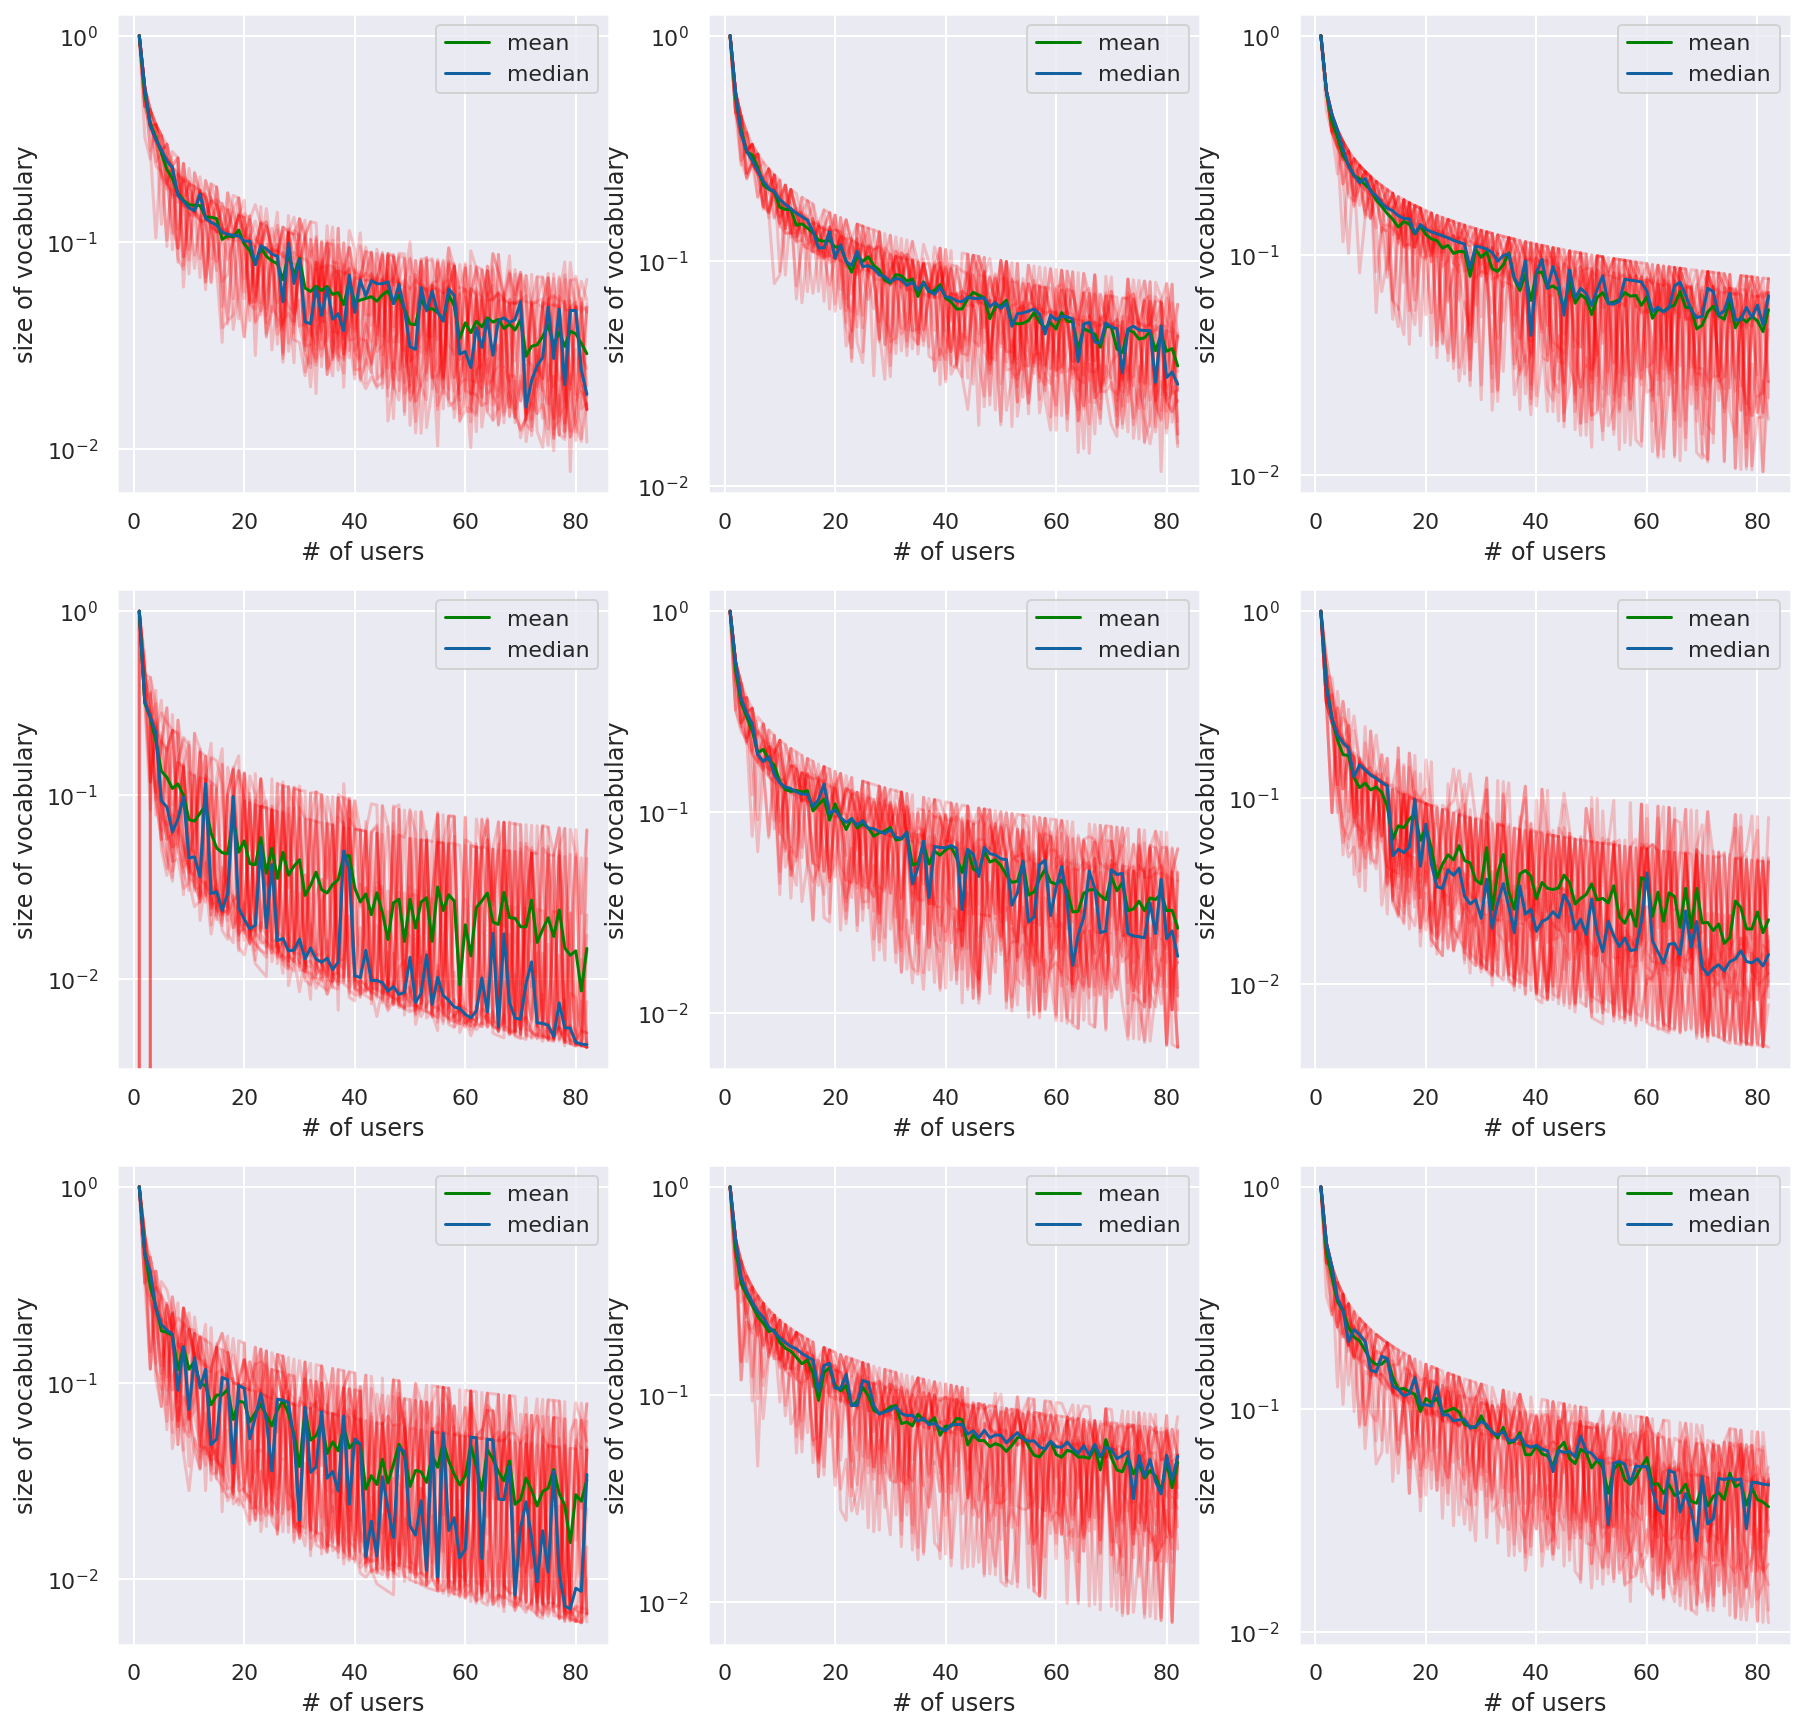

In [178]:
asymp_df = str2vocab(read_form("../data/raw/forms/Asymptotic_Emoji_Agreement_1.csv"))

asymp_df.drop(columns=['👕','🚓'],inplace=True)

plot_multi_trajectories(asymp_df)

## Completion Time Analysis

Median: 53 seconds
Mean: 68 seconds


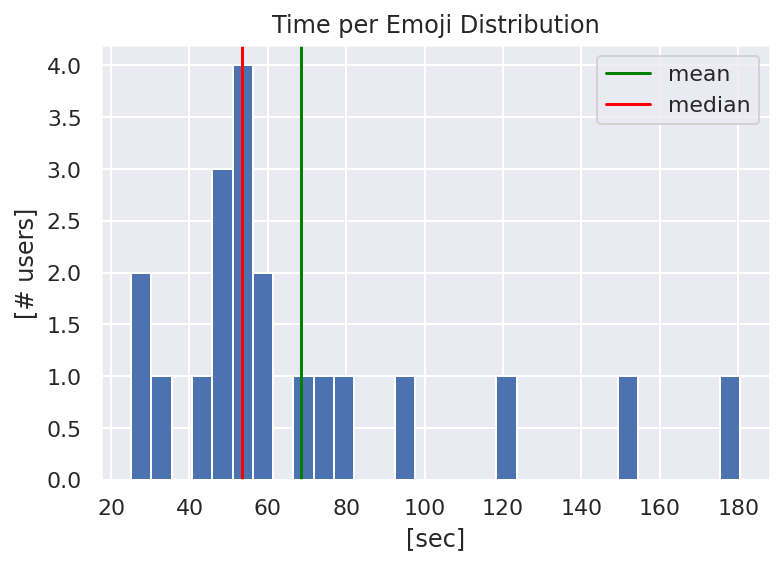

In [73]:
asymp_meta_df = read_meta("../data/raw/forms/emoji10/Emojis10_4META.csv",asymp_df.shape[1])

fig,ax = plt.subplots(1)
plot_emoji_time(asymp_meta_df,ax)